In [1]:
from copy import deepcopy
import tqdm.notebook

import jax.numpy as jnp
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch

from adaptive_mcmc.distributions.distribution import (
    GaussianMixture,
    FunnelDistribution,
    Gaussian,
    BananaDistribution,
)
from adaptive_mcmc.samplers import (
    base_sampler,
    mala,
    fishermala,
    hmc,
    hmcadaptive,
)
from adaptive_mcmc.samplers.stopping_rule import NoStop
from adaptive_mcmc.tools.benchmark import BenchmarkUtils
from adaptive_mcmc.tools.metrics import compute_ess, compute_emd

from typing import Tuple, Optional

2025-05-25 00:30:09.476473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748122209.487824   31024 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748122209.490924   31024 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
seed = 123
torch.manual_seed(seed)

device = "cpu"

hparams = {
    "mala": {
        "common": mala.MALACommonParams(
            sigma=1e0,
            sigma_lr=1e-2,    
        ),
    },
    # "fisher_mala": {
    #     "common": fishermala.FisherMALACommonParams(
    #         dampening=100,
    #         sigma=1e0,
    #         sigma_lr=1e-2,
    #     ),
    # },
    "hmc_vanilla": {
        "common": hmc.HMCCommonParams(
            lf_step_count=50,
            lf_step_size=1e-1,
            lf_step_size_max=5e-1,
            #lf_step_size_adaptive_bad_traj_period=7,
        ),
        "fixed": hmc.HMCFixedParams(no_grad=True, stop_grad=False),
    },
    "taylor_nograd": {
        "common": hmcadaptive.HMCAdaptiveCommonParams(
            lf_step_count=50,
            lf_step_size=1e-1,
            lf_step_size_max=5e-1,
            #lf_step_size_adaptive_bad_traj_period=7,
            learning_rate=3e-4,
            truncation_level_prob=0.5,
            min_truncation_level=2,
            entropy_weight=1e-1,
            entropy_weight_min=1e-3,
            entropy_weight_max=1e2,
            penalty_weight_max=1e1,
            penalty_weight=1e-3,
            penalty_weight_adaptive_rate=1e-3,
            clip_grad_value=1e1,
        ),
        "fixed": hmcadaptive.HMCAdaptiveFixedParams(
            prec_init_scale=1e-9,
            no_grad=True,
            stop_grad=False,
            backprop_method="approx",
            prec_type="tridiag",
            # iter_count=10000,
            # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
        ),
    },
    "lanczos_nograd": {
        "common": hmcadaptive.HMCAdaptiveCommonParams(
            lf_step_count=50,
            lf_step_size=1e-1,
            lf_step_size_max=5e-1,
            #lf_step_size_adaptive_bad_traj_period=7,
            learning_rate=3e-4,
            entropy_weight=1e-1,
            entropy_weight_min=1e-3,
            entropy_weight_max=1e2,
            clip_grad_value=1e1,
            lanczos_steps=8,
            krylov_probe_vectors=1,
            # iter_count=10000,
            # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
        ),
        "fixed": hmcadaptive.HMCAdaptiveFixedParams(
            prec_init_scale=1e-9,
            no_grad=True,
            stop_grad=False,
            backprop_method="approx",
            prec_type="tridiag",
            trace_method=hmcadaptive.TraceMethod.HUTCH_LANCZOS,
            # iter_count=10000,
            # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
        ),
    },
    # "hmcadaptive_hutch_taylor": {
    #     "common": hmcadaptive.HMCAdaptiveCommonParams(
    #         lf_step_count=25,
    #         lf_step_size=0.1,
    #         learning_rate=1e-3,
    #         truncation_level_prob=0.5,
    #         min_truncation_level=2,
    #         entropy_weight=1e-1,
    #         entropy_weight_min=1e-3,
    #         entropy_weight_max=1e2,
    #         penalty_weight_max=1e1,
    #         penalty_weight=1e-3,
    #         penalty_weight_adaptive_rate=1e-3,
    #         clip_grad_value=1e1,
    #     ),
    #     "fixed": hmcadaptive.HMCAdaptiveFixedParams(
    #         prec_init_scale=1e-1,
    #         no_grad=False,
    #         stop_grad=False,
    #         prec_type="tridiag",
    #         # iter_count=10000,
    #         # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    #     ),
    # },
    # "hmcadaptive_hutch_lanczos": hmcadaptive.HMCAdaptiveParams(
    #     lf_step_count=5,
    #     lf_step_size=0.1,
    #     learning_rate=1e-2,
    #     entropy_weight=1e-1,
    #     entropy_weight_min=1e-3,
    #     entropy_weight_max=1e2,
    #     clip_grad_value=1e6,
    #     prec_init_scale=1e0,
    #     trace_method=hmcadaptive.TraceMethod.HUTCH_LANCZOS,
    #     lanczos_steps=4,
    #     krylov_probe_vectors=1,
    #     # iter_count=10000,
    #     # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    # ),
    # "hmcadaptive_noent": hmcadaptive.HMCAdaptiveParams(
    #     lf_step_count=5,
    #     lf_step_size=0.1,
    #     learning_rate=1e-4,
    #     clip_grad_value=1e6,
    #     prec_init_scale=1e0,
    #     entropy_method="none",
    #     # iter_count=10000,
    #     # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    # ),
    # "hmcadaptive_fullent": hmcadaptive.HMCAdaptiveParams(
    #     lf_step_count=5,
    #     lf_step_size=0.1,
    #     learning_rate=1e-2,
    #     entropy_weight=1e-1,
    #     entropy_weight_min=1e-3,
    #     entropy_weight_max=1e2,
    #     clip_grad_value=1e6,
    #     prec_init_scale=1e0,
    #     trace_method=hmcadaptive.TraceMethod.HUTCH_LANCZOS,
    #     lanczos_steps=4,
    #     krylov_probe_vectors=1,
    #     entropy_method="full",
    #     # iter_count=10000,
    #     # scheduler_cls=hmcadaptive.WarmupCosineAnnealingScheduler
    # ),
}

In [3]:
def get_random_GM(
    gaussian_count: int,
    dimension: int,
    cube: float,
    eps: float=5e-1,
    scale: float=5.,
):
    true_means = torch.rand((gaussian_count, dimension)) * cube - cube / 2
    scales = torch.rand((gaussian_count, dimension)) * scale

    while True:
        try:
            true_covs = torch.rand((gaussian_count, dimension, dimension))
            true_covs, _ = torch.linalg.qr(true_covs)
        
            true_covs = (
                true_covs @ torch.diag_embed(scales) @ true_covs.permute(0, 2, 1) 
                + eps * torch.eye(dimension).unsqueeze(0)
            )
            
            # true_covs = (
            #     true_covs @ true_covs.permute(0, 2, 1) +
            #     torch.eye(dimension).repeat(gaussian_count, 1, 1)
            # )
        
            gm = GaussianMixture(
                true_means,
                true_covs,
                torch.full((gaussian_count,), 1/gaussian_count, dtype=torch.float64)
            )
            break
        except ValueError:
            pass
            
    return gm, true_means

In [4]:
def get_random_GM(
    gaussian_count: int,
    dimension: int,
    cube: float,
    eps: float = 5e-1,
    scale: float = 1.0,
    *,
    seed: Optional[int] = None,
    device: torch.device | str = "cpu",
    dtype: torch.dtype = torch.float32,
) -> Tuple[GaussianMixture, torch.Tensor]:
    """
    Create a reproducible random Gaussian Mixture.

    Parameters
    ----------
    gaussian_count : int      # number of components
    dimension      : int      # dimensionality
    cube           : float    # component means ∈ (-cube/2, cube/2)
    eps            : float    # ε·I added to each covariance
    scale          : float    # upper–bound on random eigen-scales
    seed           : int|None # RNG seed for reproducibility
    device         : str|torch.device
    dtype          : torch.dtype

    Returns
    -------
    gm          : GaussianMixture
    true_means  : Tensor (gaussian_count, dimension)
    """
    g = torch.Generator(device=device)
    if seed is not None:
        g.manual_seed(seed)

    true_means = (
        torch.rand((gaussian_count, dimension), generator=g, device=device, dtype=dtype)
        * cube - cube/2
    )

    scales = torch.rand((gaussian_count, dimension), generator=g, device=device, dtype=dtype) * scale

    while True:
        try:
            # Q = torch.rand((gaussian_count, dimension, dimension), generator=g, device=device, dtype=dtype)
            # Q, _ = torch.linalg.qr(Q)
            Q_list = []
            for _ in range(gaussian_count):
                q = torch.randn((dimension, dimension), generator=g, device=device, dtype=dtype)
                q, _ = torch.linalg.qr(q)
                Q_list.append(q)
            
            Q = torch.stack(Q_list, dim=0)  # shape: (gaussian_count, dimension, dimension)


            true_covs = (
                Q @ torch.diag_embed(scales) @ Q.transpose(-1, -2)
                + eps * torch.eye(dimension, device=device, dtype=dtype).unsqueeze(0)
            )

            gm = GaussianMixture(
                true_means,
                true_covs,
                torch.full((gaussian_count,), 1.0 / gaussian_count, device=device, dtype=dtype),
            )
            break
        except ValueError:
            continue

    return gm, true_means

In [5]:
def generate_simplex(d: int) -> torch.Tensor:
    I = torch.eye(d)
    
    ones = torch.ones((d, d)) / (d+1)
    v1d = I - ones
    vdp1 = -torch.ones((1, d)) / (d+1)
    return torch.cat([v1d, vdp1], dim=0)


def get_toeplitz_GM(dimension: int, cube: float, rho: float=0.99, sigma: float=1.):
    true_means = generate_simplex(dimension) * cube

    inds = torch.arange(dimension)
    power = torch.abs(inds.unsqueeze(0) - inds.unsqueeze(1))

    true_covs = sigma ** 2 * rho ** power
    true_covs = true_covs.repeat(dimension + 1, 1, 1)

    gm = GaussianMixture(
        true_means,
        true_covs,
        torch.ones(dimension + 1) / (dimension + 1)
    )

    return gm, true_means


def get_toeplitz_gaussian(dimension: int,
                          mean: float = None,
                          rho: float = 0.99,
                          sigma: float = 1.0) -> tuple:
    if mean is None:
        mean = torch.zeros(dimension)
        
    inds = torch.arange(dimension)
    power = torch.abs(inds.unsqueeze(0) - inds.unsqueeze(1))
    cov = (sigma ** 2) * (rho ** power)
    
    return Gaussian(mean=mean, cov=cov), mean.unsqueeze(0)


def get_illcond_gaussian(dimension: int,
                         mean: float = None,
                         min_v: float = 1e-2,
                         max_v: float = 1e2) -> tuple:
    if mean is None:
        mean = torch.zeros(dimension)
    elif isinstance(mean, (float, int)):
        mean = torch.full((dimension,), float(mean))
    else:
        mean = torch.tensor(mean, dtype=torch.float32)

    # Create log-spaced eigenvalues (ill-conditioned spectrum)
    eigvals = torch.logspace(torch.log10(torch.tensor(min_v)), 
                             torch.log10(torch.tensor(max_v)), 
                             steps=dimension)

    # Construct diagonal covariance matrix
    cov = torch.diag(eigvals)

    return Gaussian(mean=mean, cov=cov), mean.unsqueeze(0)
    

def sample_se_covariance_torch(dimension, scale=4., noise=0.01, seed=None, device='cpu'):
    if seed is not None:
        torch.manual_seed(seed)

    x = torch.linspace(0, scale, dimension)

    x1 = x.unsqueeze(1)
    x2 = x.unsqueeze(0)
    dist_squared = (x1 - x2) ** 2

    K = torch.exp(-0.5 * dist_squared / (0.1 * scale**2))

    K += noise * torch.eye(dimension, device=device)

    return x, K
    
def get_deterministic_gaussian_se(dimension: int,
                                  mean: float = None,) -> tuple:
    if mean is None:
        mean = torch.zeros(dimension)
        
    _, cov = sample_se_covariance_torch(dimension)
    
    return Gaussian(mean=mean, cov=cov), mean.unsqueeze(0)

def get_banana(dimension: int, b: float = 2.):
    mean = torch.zeros(dimension)
    return BananaDistribution(dimension, b), mean.unsqueeze(0)

In [6]:
# dist = FunnelDistribution(32, scale=3)

#dist, _ = get_toeplitz_gaussian(256, rho=0.95)
# dist, _ = get_deterministic_gaussian_se(32)
#dist, _ = get_illcond_gaussian(128)
dist, _ = get_banana(32, b=20.)

# dist, _ = get_random_GM(gaussian_count=25, dimension=32, cube=2., scale=2.,)
# dist, _ = get_toeplitz_GM(dimension=32, cube=2., rho=0.9)


samples = dist.sample(5000).detach().numpy()

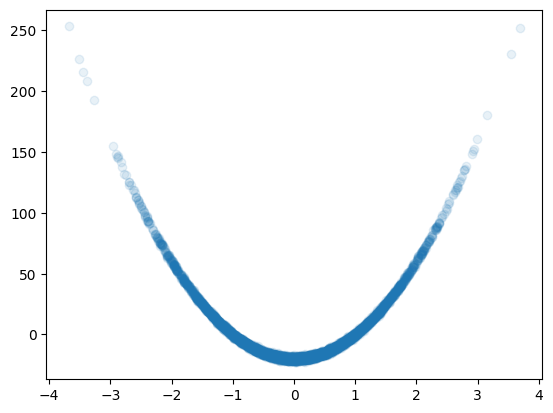

In [7]:
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1)

In [8]:
def dist_factory(name, dimension, cube=2., scale=2., funnel_scale=3, gaussian_count=25, rho=0.95, sigma=1.,
                 min_v=1e-3, max_v=1e3, bending=20.
                ):
    if name == "random_gm":
        return get_random_GM(gaussian_count=gaussian_count, dimension=dimension, cube=cube, scale=scale)
    elif name == "toeplitz_gm":
        return get_toeplitz_GM(dimension, cube=cube, rho=rho, sigma=sigma)
    elif name == "toeplitz_gaussian":
        return get_toeplitz_gaussian(dimension, rho=rho, sigma=sigma)
    elif name == "deterministic_gaussian_se":
        return get_deterministic_gaussian_se(dimension)
    elif name == "funnel":
        return FunnelDistribution(dimension, scale=funnel_scale), torch.zeros(1, dimension)
    elif name == "illcond_gaussian":
        return get_illcond_gaussian(dimension, min_v=min_v, max_v=max_v)
    elif name == "banana":
        return get_banana(dimension, b=bending)

In [9]:
import pandas as pd
from scipy.stats import norm
from itertools import combinations


def drop_static_chains(samples: torch.Tensor, eps: float = 0.0):
    var_per_chain = samples.var(dim=0, unbiased=False)

    static = (var_per_chain <= eps).all(dim=-1)
    keep_mask = ~static

    return samples[:, keep_mask, :], keep_mask.sum().item()


def z_test(dim_stat):
    all_results = {}
    for dim, df in dim_stat.items():
        recs = []
        algs = df.columns
        for A, B in combinations(reversed(algs), 2):
    
            mA, sA = df.loc['ess_mean', A], df.loc['ess_conf_sigma', A]
            mB, sB = df.loc['ess_mean', B], df.loc['ess_conf_sigma', B]
            z_ess = (mA - mB) / (sA**2 + sB**2)**0.5
            p_ess = norm.sf(z_ess)
    
            tA, seA = df.loc['tv_mean', A], df.loc['tv_conf_sigma', A]
            tB, seB = df.loc['tv_mean', B], df.loc['tv_conf_sigma', B]
            z_tv = (tB - tA) / (seA**2 + seB**2)**0.5
            p_tv = norm.sf(z_tv)
            recs.append({
                'alg_A': A, 'alg_B': B,
                'z(ESS_A>B)': z_ess, 'p(ESS_A>B)': p_ess,
                'z(TV_A<B)': z_tv,  'p(TV_A<B)': p_tv,
            })
        all_results[dim] = pd.DataFrame.from_records(recs)
    return all_results


def compute_results(hist_data, algs, dist_name=None):
    dim_stat = {}

    for dimension in tqdm.notebook.tqdm(dimensions, desc="dimension"):
        rows = []
        for alg in tqdm.notebook.tqdm(algs, desc="alg", leave=False):
            obj = hist_data[dimension][alg]
            cache = obj["cache"]
            pure_runtime = obj["pure_runtime"]
    
            clean_samples, n_kept = drop_static_chains(cache.samples)
    
            metrics = BenchmarkUtils.compute_metrics(clean_samples,
                                                     cache.true_samples)
            metrics["runtime"]      = pure_runtime
            metrics["chains_kept"]  = n_kept
            rows.append(metrics)
    
        df = pd.DataFrame(rows, index=list(algs.keys())).T
        dim_stat[dimension] = df
        print(f"\ndim={dimension}, dist={dist_name}\n", df)
        print(z_test(dim_stat))
    
    return dim_stat

In [10]:
def run_experiment(dist_name, log=[]):
    hist_data = {}
    loge = {
        "hist_data": hist_data,
        "algs": algs,
        "dist_name": dist_name,
        "dim_stat": None,
    }
    log.append(loge)
    runtime = {
        dimension: dict()
        for dimension in dimensions
    }
    pure_runtime = deepcopy(runtime)
    distance_to_mass_points = 1.
    
    for dimension in tqdm.notebook.tqdm(dimensions):
        print("Processing dimension", dimension)
        hist_data[dimension] = {}
        target_dist, true_means = dist_factory(dist_name, dimension)
        
        # target_dist, true_means = get_random_GM(gaussian_count, dimension, cube)
        # gm, true_means = get_deterministic_GM(dimension, cube)
        # true_samples = gm.sample(sample_count)
    
        # target_dist = FunnelDistribution(dimension, scale=scale)
        
        # target_dist, _ = get_deterministic_gaussian(dimension, rho=0.8)
        # target_dist, _ = get_deterministic_gaussian_se(dimension)
    
        # true_means = torch.zeros(1, dimension)
        true_samples = target_dist.sample(sample_count)
        
        starting_points = BenchmarkUtils.generate_starting_points(
            chain_count, dimension,
            true_means,
            distance_to_mass_points,
        )
    
        common_params = base_sampler.CommonParams(
            target_dist=target_dist,
            starting_point=starting_points.clone(),
            proposal_dist=torch.distributions.MultivariateNormal(
                torch.zeros(dimension, device=device),
                torch.eye(dimension, device=device),
            ),
        )
    
        for alg in algs:
            print("-" * 80)
            base_meta_adj = hparams[alg]["common"].copy_update(common_params)
            # if hasattr(base_meta_adj, "sigma"):
            #     base_meta_adj.sigma /= dimension
    
            algs[alg].load_params(base_meta_adj)
            algs[alg].load_true_samples(true_samples)
            algs[alg].run()
    
            loge["hist_data"][dimension][alg] = {
                "cache": algs[alg].pipeline.sample_blocks[-1].iteration.cache,
                "stop_data_hist": algs[alg].pipeline.sample_blocks[-1].stop_data_hist,
                "runtime": algs[alg].pipeline.runtime,
                "pure_runtime": algs[alg].pipeline.pure_runtime,
            }
        print()
    
    dim_stat = compute_results(hist_data, algs, dist_name)
    loge["dim_stat"] = dim_stat

In [11]:
def moving_average(x, window_size=10):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

def print_log(log):
    for entry in log:
        for dimension in dimensions:
            print(f"\ndim={dimension}, dist={entry['dist_name']}\n", entry["dim_stat"][dimension])

In [12]:
chain_count = 30
sample_count = 5000
sample_iter_limit = 5000
burn_in_iter_count = 5000
step_size_burn_in_iter_count = 2500
probe_period = 250000

tv_threshold = 0.05
tail_count_cap = 1000
# stopping_rule = TVStop(threshold=tv_threshold, density_probe_count=1000,
#                        projection_count=25, tail_count_cap=tail_count_cap)

stopping_rule = NoStop(
    density_probe_count=500,
    projection_count=25,
    tail_count_cap=tail_count_cap,
)


dist_names = [
    # "toeplitz_gm",
    # "toeplitz_gaussian",
    "funnel",
    "random_gm",
    "illcond_gaussian",
    #"banana",
]

dimensions = [8, 16, 32, 64, 128, 256]
log = []

for dist_name in dist_names:
    algs = {
        # "mala": mala.MALAVanilla(
        #     pipeline=None,
        #     name="MALA",
        #     sigma_burn_in_params=hparams["mala"]["common"].copy(),
        #     sigma_burn_in_iter_count=burn_in_iter_count + step_size_burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
        # "fisher_mala": fishermala.FisherMALAVanilla(
        #     pipeline=None,
        #     name="FisherMALA",
        #     sigma_burn_in_iter_count=step_size_burn_in_iter_count,
        #     #common_params=hparams["fisher_mala"]["common"].copy(),
        #     #fixed_params=hparams["fisher_mala"]["fixed"],
        #     prec_burn_in_iter_count=burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
        "hmc_vanilla": hmc.HMCVanilla(
            pipeline=None,
            name="HMCVanilla",
            common_params=hparams["hmc_vanilla"]["common"].copy(),
            fixed_params=hparams["hmc_vanilla"]["fixed"],
            step_size_burn_in_iter_count=step_size_burn_in_iter_count,
            sample_iter_count=sample_iter_limit,
            burn_in_iter_count=burn_in_iter_count,
            stopping_rule=stopping_rule,
            probe_period=probe_period,
            mask_adapt_step_size_required=[True, False, True],
        ),
        "taylor_nograd": hmcadaptive.HMCAdaptive(
            pipeline=None,
            name="HMCAdaptiveHutchTaylorNoGrad",
            common_params=hparams["taylor_nograd"]["common"].copy(),
            fixed_params=hparams["taylor_nograd"]["fixed"],
            step_size_burn_in_iter_count=step_size_burn_in_iter_count,
            sample_iter_count=sample_iter_limit,
            burn_in_iter_count=burn_in_iter_count,
            stopping_rule=stopping_rule,
            probe_period=probe_period,
            mask_adapt_step_size_required=[True, False, True],
        ),
        "lanczos_nograd": hmcadaptive.HMCAdaptive(
            pipeline=None,
            name="HMCAdaptiveHutchLanczosNoGrad",
            common_params=hparams["lanczos_nograd"]["common"].copy(),
            fixed_params=hparams["lanczos_nograd"]["fixed"],
            step_size_burn_in_iter_count=step_size_burn_in_iter_count,
            sample_iter_count=sample_iter_limit,
            burn_in_iter_count=burn_in_iter_count,
            stopping_rule=stopping_rule,
            probe_period=probe_period,
            mask_adapt_step_size_required=[True, False, True],
        ),
        # "hmcadaptive_hutch_taylor": hmcadaptive.HMCAdaptive(
        #     pipeline=None,
        #     name="HMCAdaptiveHutchTaylor",
        #     common_params=hparams["hmcadaptive_hutch_taylor"]["common"].copy(),
        #     fixed_params=hparams["hmcadaptive_hutch_taylor"]["fixed"],
        #     step_size_burn_in_iter_count=step_size_burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     burn_in_iter_count=burn_in_iter_count,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
        # "hmcadaptive_fullent": hmcadaptive.HMCAdaptive(
        #     pipeline=None,
        #     name="HMCAdaptiveFullEnt",
        #     params=hparams["hmcadaptive_fullent"].copy(),
        #     step_size_burn_in_iter_count=step_size_burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     burn_in_iter_count=burn_in_iter_count,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
        # "hmcadaptive_noent": hmcadaptive.HMCAdaptive(
        #     pipeline=None,
        #     name="HMCAdaptiveNoEnt",
        #     params=hparams["hmcadaptive_noent"].copy(),
        #     step_size_burn_in_iter_count=step_size_burn_in_iter_count,
        #     sample_iter_count=sample_iter_limit,
        #     burn_in_iter_count=burn_in_iter_count,
        #     stopping_rule=stopping_rule,
        #     probe_period=probe_period,
        # ),
    }
    run_experiment(dist_name, log=log)

  0%|          | 0/6 [00:00<?, ?it/s]

Processing dimension 8
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.30060094594955444
max_step_size=0.3131302297115326
broken_traj=1376
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.15733543038368225
max_step_size=0.2754693329334259
broken_traj=1752
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.22740496695041656
max_step_size=0.2282056212425232
broken_traj=2295
Runtime: 149.25s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.3051062822341919
max_step_size=0.31191548705101013
broken_traj=1381
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2283099740743637
max_step_size=0.29458749294281006
broken_traj=1554
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2903265655040741
max_step_size=0.2904854714870453
broken_traj=1592
Runtime: 227.68s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.31326618790626526
max_step_size=0.3181523382663727
broken_traj=1328
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.21119575202465057
max_step_size=0.29385313391685486
broken_traj=1562
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2550927698612213
max_step_size=0.2597380578517914
broken_traj=1928
Runtime: 246.30s

Processing dimension 16
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.3082488179206848
max_step_size=0.32787710428237915
broken_traj=1228
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.194009467959404
max_step_size=0.2994670867919922
broken_traj=1493
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2687875032424927
max_step_size=0.2767050862312317
broken_traj=1722
Runtime: 142.90s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.3225317895412445
max_step_size=0.32902607321739197
broken_traj=1205
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2767353951931
max_step_size=0.31899356842041016
broken_traj=1296
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.31781959533691406
max_step_size=0.31899356842041016
broken_traj=1296
Runtime: 225.78s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.32404354214668274
max_step_size=0.3316724896430969
broken_traj=1202
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.26780951023101807
max_step_size=0.3194883167743683
broken_traj=1314
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.3163454830646515
max_step_size=0.31671980023384094
broken_traj=1336
Runtime: 248.12s

Processing dimension 32
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.27084237337112427
max_step_size=0.2760152220726013
broken_traj=1713
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.19503720104694366
max_step_size=0.2585233747959137
broken_traj=1907
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.24093391001224518
max_step_size=0.2471754550933838
broken_traj=2035
Runtime: 158.59s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.2690824568271637
max_step_size=0.2742091119289398
broken_traj=1729
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2510131895542145
max_step_size=0.270059198141098
broken_traj=1770
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2558935880661011
max_step_size=0.270059198141098
broken_traj=1770
Runtime: 240.90s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.2600758373737335
max_step_size=0.27496737241744995
broken_traj=1724
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.24151143431663513
max_step_size=0.2708660662174225
broken_traj=1767
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2646217346191406
max_step_size=0.2695139944553375
broken_traj=1783
Runtime: 265.54s

Processing dimension 64
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.21386823058128357
max_step_size=0.22303716838359833
broken_traj=2336
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.17252546548843384
max_step_size=0.21366897225379944
broken_traj=2461
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.20351429283618927
max_step_size=0.20430587232112885
broken_traj=2593
Runtime: 168.95s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.21003249287605286
max_step_size=0.22178034484386444
broken_traj=2335
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.20174500346183777
max_step_size=0.22029298543930054
broken_traj=2358
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.21265874803066254
max_step_size=0.22029298543930054
broken_traj=2358
Runtime: 257.09s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.22282765805721283
max_step_size=0.2239433228969574
broken_traj=2323
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.21234051883220673
max_step_size=0.22170408070087433
broken_traj=2352
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.2102224975824356
max_step_size=0.22170408070087433
broken_traj=2352
Runtime: 282.18s

Processing dimension 128
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.17426125705242157
max_step_size=0.20588384568691254
broken_traj=2602
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.14089225232601166
max_step_size=0.1977284997701645
broken_traj=2720
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1542970836162567
max_step_size=0.15992198884487152
broken_traj=3281
Runtime: 184.65s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.17872844636440277
max_step_size=0.20166689157485962
broken_traj=2689
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.16749557852745056
max_step_size=0.19868779182434082
broken_traj=2725
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1915183812379837
max_step_size=0.19868779182434082
broken_traj=2725
Runtime: 279.00s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.1783377230167389
max_step_size=0.1914786994457245
broken_traj=2788
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.16673603653907776
max_step_size=0.18878234922885895
broken_traj=2826
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.18369759619235992
max_step_size=0.18878234922885895
broken_traj=2826
Runtime: 308.70s

Processing dimension 256
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.11670594662427902
max_step_size=0.2628284990787506
broken_traj=2019
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.1063769981265068
max_step_size=0.2583844065666199
broken_traj=2067
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.12679509818553925
max_step_size=0.13442875444889069
broken_traj=3722
Runtime: 212.30s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.12762299180030823
max_step_size=0.2571655511856079
broken_traj=2140
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.12347676604986191
max_step_size=0.2561210095882416
broken_traj=2158
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.21146507561206818
max_step_size=0.2519662082195282
broken_traj=2185
Runtime: 313.54s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.13757744431495667
max_step_size=0.23431621491909027
broken_traj=2262
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.13290290534496307
max_step_size=0.2330809384584427
broken_traj=2282
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.19235020875930786
max_step_size=0.22234274446964264
broken_traj=2377
Runtime: 348.07s



dimension:   0%|          | 0/6 [00:00<?, ?it/s]

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=8, dist=funnel
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.342284       0.320596        0.416649
ess_conf_sigma     0.029175       0.028133        0.039440
tv_mean            0.085239       0.069880        0.074748
tv_conf_sigma      0.004777       0.004413        0.006019
runtime          148.651990     226.331241      245.359711
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    1.982664    0.023702  -0.652287   0.742892
1  lanczos_nograd    hmc_vanilla    1.515829    0.064781   1.365251   0.086087
2   taylor_nograd    hmc_vanilla   -0.535107    0.703712   2.361672   0.009096}


alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=16, dist=funnel
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.455800       0.349065        0.374049
ess_conf_sigma     0.032762       0.030311        0.041354
tv_mean            0.068217       0.074943        0.073221
tv_conf_sigma      0.003269       0.005410        0.004272
runtime          142.333083     224.879872      247.175021
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    1.982664    0.023702  -0.652287   0.742892
1  lanczos_nograd    hmc_vanilla    1.515829    0.064781   1.365251   0.086087
2   taylor_nograd    hmc_vanilla   -0.535107    0.703712   2.361672   0.009096, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    0.487279    0.313030   0.249841   0.401355
1  lanczos_nograd    hmc_vanilla   -1.549506    0.939370  -0.930185   0.823862
2  

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=32, dist=funnel
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.398348       0.326946        0.433709
ess_conf_sigma     0.040611       0.034397        0.029327
tv_mean            0.080407       0.075956        0.079885
tv_conf_sigma      0.004427       0.005160        0.005695
runtime          157.944978     239.938679      264.512402
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    1.982664    0.023702  -0.652287   0.742892
1  lanczos_nograd    hmc_vanilla    1.515829    0.064781   1.365251   0.086087
2   taylor_nograd    hmc_vanilla   -0.535107    0.703712   2.361672   0.009096, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    0.487279    0.313030   0.249841   0.401355
1  lanczos_nograd    hmc_vanilla   -1.549506    0.939370  -0.930185   0.823862
2  

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=64, dist=funnel
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.378383       0.335944        0.335208
ess_conf_sigma     0.034956       0.034759        0.032524
tv_mean            0.091222       0.089048        0.089302
tv_conf_sigma      0.006199       0.009070        0.008076
runtime          168.283647     256.097755      281.131919
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    1.982664    0.023702  -0.652287   0.742892
1  lanczos_nograd    hmc_vanilla    1.515829    0.064781   1.365251   0.086087
2   taylor_nograd    hmc_vanilla   -0.535107    0.703712   2.361672   0.009096, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    0.487279    0.313030   0.249841   0.401355
1  lanczos_nograd    hmc_vanilla   -1.549506    0.939370  -0.930185   0.823862
2  

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=128, dist=funnel
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.323472       0.330443        0.366803
ess_conf_sigma     0.032855       0.028817        0.029979
tv_mean            0.119390       0.125392        0.118922
tv_conf_sigma      0.011790       0.009824        0.013984
runtime          183.911039     277.930945      307.366570
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    1.982664    0.023702  -0.652287   0.742892
1  lanczos_nograd    hmc_vanilla    1.515829    0.064781   1.365251   0.086087
2   taylor_nograd    hmc_vanilla   -0.535107    0.703712   2.361672   0.009096, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    0.487279    0.313030   0.249841   0.401355
1  lanczos_nograd    hmc_vanilla   -1.549506    0.939370  -0.930185   0.823862
2 

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=256, dist=funnel
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.367077       0.383353        0.399913
ess_conf_sigma     0.040350       0.027963        0.029555
tv_mean            0.191970       0.183459        0.166396
tv_conf_sigma      0.023106       0.013660        0.017180
runtime          211.455676     312.311889      346.656656
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    1.982664    0.023702  -0.652287   0.742892
1  lanczos_nograd    hmc_vanilla    1.515829    0.064781   1.365251   0.086087
2   taylor_nograd    hmc_vanilla   -0.535107    0.703712   2.361672   0.009096, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd    0.487279    0.313030   0.249841   0.401355
1  lanczos_nograd    hmc_vanilla   -1.549506    0.939370  -0.930185   0.823862
2 

  0%|          | 0/6 [00:00<?, ?it/s]

Processing dimension 8
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
Runtime: 248.87s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
Runtime: 389.52s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
Runtime: 423.29s

Processing dimension 16
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.49992257356643677
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49992257356643677
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
Runtime: 263.92s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.49977174401283264
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49977174401283264
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
Runtime: 414.90s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.4999486804008484
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4999486804008484
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4999573528766632
max_step_size=0.5
broken_traj=0
Runtime: 453.11s

Processing dimension 32
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.4997763931751251
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4997763931751251
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4993538558483124
max_step_size=0.5
broken_traj=0
Runtime: 311.53s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.49975648522377014
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49975648522377014
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.5
max_step_size=0.5
broken_traj=0
Runtime: 492.24s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.4997880756855011
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4997880756855011
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49975332617759705
max_step_size=0.5
broken_traj=0
Runtime: 537.13s

Processing dimension 64
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.499117910861969
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.499117910861969
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4984787702560425
max_step_size=0.5
broken_traj=0
Runtime: 437.26s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.4994211792945862
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4994211792945862
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49999427795410156
max_step_size=0.5
broken_traj=0
Runtime: 678.46s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.4989316165447235
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4989316165447235
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49946579337120056
max_step_size=0.5
broken_traj=0
Runtime: 739.39s

Processing dimension 128
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.497719407081604
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.497719407081604
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4975868761539459
max_step_size=0.5
broken_traj=0
Runtime: 674.14s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.49784407019615173
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49784407019615173
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4998995065689087
max_step_size=0.5
broken_traj=0
Runtime: 1049.30s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.49877306818962097
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49877306818962097
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49910852313041687
max_step_size=0.5
broken_traj=0
Runtime: 1136.43s

Processing dimension 256
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.4933825731277466
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4933825731277466
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49111732840538025
max_step_size=0.5
broken_traj=0
Runtime: 1497.98s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.49594148993492126
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49594148993492126
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.4993912875652313
max_step_size=0.5
broken_traj=0
Runtime: 2298.59s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.49459108710289
max_step_size=0.5
broken_traj=0
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.49459108710289
max_step_size=0.5
broken_traj=0
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.498052179813385
max_step_size=0.5
broken_traj=0
Runtime: 2484.13s



dimension:   0%|          | 0/6 [00:00<?, ?it/s]

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=8, dist=random_gm
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.562775       0.295242        0.528651
ess_conf_sigma     0.001804       0.002269        0.003916
tv_mean            0.010925       0.011575        0.009608
tv_conf_sigma      0.000884       0.001007        0.000790
runtime          247.931967     388.114305      421.429769
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   51.569948         0.0   1.536759   0.062176
1  lanczos_nograd    hmc_vanilla   -7.913580         1.0   1.110716   0.133345
2   taylor_nograd    hmc_vanilla  -92.295436         1.0  -0.485263   0.686255}


alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=16, dist=random_gm
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.812024       0.508399        0.817327
ess_conf_sigma     0.001691       0.001302        0.002280
tv_mean            0.008902       0.010097        0.009315
tv_conf_sigma      0.000662       0.000859        0.000766
runtime          262.829723     413.457613      451.210301
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   51.569948         0.0   1.536759   0.062176
1  lanczos_nograd    hmc_vanilla   -7.913580         1.0   1.110716   0.133345
2   taylor_nograd    hmc_vanilla  -92.295436         1.0  -0.485263   0.686255, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd  117.678980    0.000000   0.679790   0.248319
1  lanczos_nograd    hmc_vanilla    1.868433    0.030851  -0.407698   0.658252


alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=32, dist=random_gm
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.788041       0.721297        0.771152
ess_conf_sigma     0.001413       0.001754        0.001267
tv_mean            0.008528       0.008060        0.008185
tv_conf_sigma      0.000690       0.000616        0.000645
runtime          310.418944     490.320657      535.053814
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   51.569948         0.0   1.536759   0.062176
1  lanczos_nograd    hmc_vanilla   -7.913580         1.0   1.110716   0.133345
2   taylor_nograd    hmc_vanilla  -92.295436         1.0  -0.485263   0.686255, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd  117.678980    0.000000   0.679790   0.248319
1  lanczos_nograd    hmc_vanilla    1.868433    0.030851  -0.407698   0.658252


alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=64, dist=random_gm
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.532887       0.347447        0.665728
ess_conf_sigma     0.001744       0.001286        0.003029
tv_mean            0.009678       0.011099        0.010033
tv_conf_sigma      0.000773       0.001017        0.000859
runtime          435.427167     676.204516      736.954701
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   51.569948         0.0   1.536759   0.062176
1  lanczos_nograd    hmc_vanilla   -7.913580         1.0   1.110716   0.133345
2   taylor_nograd    hmc_vanilla  -92.295436         1.0  -0.485263   0.686255, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd  117.678980    0.000000   0.679790   0.248319
1  lanczos_nograd    hmc_vanilla    1.868433    0.030851  -0.407698   0.658252


alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=128, dist=random_gm
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.047254       0.032252        0.051957
ess_conf_sigma     0.000993       0.000544        0.001201
tv_mean            0.036950       0.043255        0.035949
tv_conf_sigma      0.004542       0.005131        0.004496
runtime          671.350251    1045.142060     1132.104383
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   51.569948         0.0   1.536759   0.062176
1  lanczos_nograd    hmc_vanilla   -7.913580         1.0   1.110716   0.133345
2   taylor_nograd    hmc_vanilla  -92.295436         1.0  -0.485263   0.686255, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd  117.678980    0.000000   0.679790   0.248319
1  lanczos_nograd    hmc_vanilla    1.868433    0.030851  -0.407698   0.658252

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=256, dist=random_gm
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.272143       0.091238        0.443208
ess_conf_sigma     0.007646       0.004056        0.012626
tv_mean            0.108980       0.114160        0.123726
tv_conf_sigma      0.013148       0.014889        0.014408
runtime         1492.207823    2292.576513     2478.316182
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd   51.569948         0.0   1.536759   0.062176
1  lanczos_nograd    hmc_vanilla   -7.913580         1.0   1.110716   0.133345
2   taylor_nograd    hmc_vanilla  -92.295436         1.0  -0.485263   0.686255, 16:             alg_A          alg_B  z(ESS_A>B)  p(ESS_A>B)  z(TV_A<B)  p(TV_A<B)
0  lanczos_nograd  taylor_nograd  117.678980    0.000000   0.679790   0.248319
1  lanczos_nograd    hmc_vanilla    1.868433    0.030851  -0.407698   0.658252

  0%|          | 0/6 [00:00<?, ?it/s]

Processing dimension 8
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.057266250252723694
max_step_size=0.492499977350235
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.057266250252723694
max_step_size=0.492499977350235
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05734305456280708
max_step_size=0.492499977350235
broken_traj=10
Runtime: 161.45s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.05735250934958458
max_step_size=0.4925000071525574
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05735250934958458
max_step_size=0.4925000071525574
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.21495583653450012
max_step_size=0.4925000071525574
broken_traj=10
Runtime: 250.08s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.05775309354066849
max_step_size=0.4933333396911621
broken_traj=9
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05775309354066849
max_step_size=0.4933333396911621
broken_traj=9
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.10697462409734726
max_step_size=0.4933333396911621
broken_traj=9
Runtime: 267.99s

Processing dimension 16
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.05546322092413902
max_step_size=0.48500001430511475
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05546322092413902
max_step_size=0.48500001430511475
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05597379431128502
max_step_size=0.48500001430511475
broken_traj=10
Runtime: 163.97s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.05698592588305473
max_step_size=0.4883333444595337
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05698592588305473
max_step_size=0.4883333444595337
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.181971475481987
max_step_size=0.4883333444595337
broken_traj=10
Runtime: 258.36s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.05646733567118645
max_step_size=0.48504170775413513
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05646733567118645
max_step_size=0.48504170775413513
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.09404142200946808
max_step_size=0.48504170775413513
broken_traj=10
Runtime: 276.20s

Processing dimension 32
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.05388477072119713
max_step_size=0.4858333170413971
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05388477072119713
max_step_size=0.4858333170413971
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05425724759697914
max_step_size=0.4858333170413971
broken_traj=10
Runtime: 167.94s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.054002318531274796
max_step_size=0.4858333170413971
broken_traj=9
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.054002318531274796
max_step_size=0.4858333170413971
broken_traj=9
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.14196337759494781
max_step_size=0.4858333170413971
broken_traj=9
Runtime: 264.90s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.05457432195544243
max_step_size=0.4891666769981384
broken_traj=9
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.05457432195544243
max_step_size=0.4891666769981384
broken_traj=9
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.07819295674562454
max_step_size=0.4891666769981384
broken_traj=9
Runtime: 283.97s

Processing dimension 64
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.04918297007679939
max_step_size=0.48083335161209106
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.04918297007679939
max_step_size=0.48083335161209106
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.04888351261615753
max_step_size=0.48083335161209106
broken_traj=10
Runtime: 181.50s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.04933994263410568
max_step_size=0.4833333194255829
broken_traj=10
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.04933994263410568
max_step_size=0.4833333194255829
broken_traj=10
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.10333024710416794
max_step_size=0.4833333194255829
broken_traj=10
Runtime: 283.24s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.049554936587810516
max_step_size=0.48333337903022766
broken_traj=9
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.049554936587810516
max_step_size=0.48333337903022766
broken_traj=9
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.06142415106296539
max_step_size=0.48333337903022766
broken_traj=9
Runtime: 306.71s

Processing dimension 128
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.04360537603497505
max_step_size=0.4866666793823242
broken_traj=7
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.04360537603497505
max_step_size=0.4866666793823242
broken_traj=7
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.04311927407979965
max_step_size=0.4866666793823242
broken_traj=7
Runtime: 196.66s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.043417297303676605
max_step_size=0.48500004410743713
broken_traj=9
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.043417297303676605
max_step_size=0.48500004410743713
broken_traj=9
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.07341483235359192
max_step_size=0.48500004410743713
broken_traj=9
Runtime: 310.12s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.04334897920489311
max_step_size=0.47999998927116394
broken_traj=9
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.04334897920489311
max_step_size=0.47999998927116394
broken_traj=9
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.0483410507440567
max_step_size=0.47999998927116394
broken_traj=9
Runtime: 336.21s

Processing dimension 256
--------------------------------------------------------------------------------
Running HMCVanilla
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.037886228412389755
max_step_size=0.492499977350235
broken_traj=7
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.037886228412389755
max_step_size=0.492499977350235
broken_traj=7
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.03764389827847481
max_step_size=0.492499977350235
broken_traj=7
Runtime: 246.60s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchTaylorNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.03755972161889076
max_step_size=0.49416667222976685
broken_traj=7
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.03755972161889076
max_step_size=0.49416667222976685
broken_traj=7
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.053422216325998306
max_step_size=0.49416667222976685
broken_traj=7
Runtime: 387.35s
--------------------------------------------------------------------------------
Running HMCAdaptiveHutchLanczosNoGrad
number of blocks: 3
processing block: 1


  0%|          | 0/2500 [00:00<?, ?it/s]

step_size=0.03819001838564873
max_step_size=0.4833333194255829
broken_traj=8
processing block: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.03819001838564873
max_step_size=0.4833333194255829
broken_traj=8
processing block: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

step_size=0.03934093564748764
max_step_size=0.4833333194255829
broken_traj=8
Runtime: 417.47s



dimension:   0%|          | 0/6 [00:00<?, ?it/s]

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=8, dist=illcond_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.350135       0.514388        0.521415
ess_conf_sigma     0.001926       0.004570        0.004062
tv_mean            0.145343       0.038965        0.056203
tv_conf_sigma      0.014912       0.002181        0.004612
runtime          160.795203     249.143797      267.029423
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    1.149193   1.252383e-01  -3.378921   
1  lanczos_nograd    hmc_vanilla   38.102304   0.000000e+00   5.710681   
2   taylor_nograd    hmc_vanilla   33.117504  8.319279e-241   7.058496   

      p(TV_A<B)  
0  9.996361e-01  
1  5.626258e-09  
2  8.415703e-13  }


alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=16, dist=illcond_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.417615       0.524907        0.480911
ess_conf_sigma     0.001331       0.003380        0.005561
tv_mean            0.151762       0.038680        0.063363
tv_conf_sigma      0.012636       0.002399        0.005083
runtime          163.313777     257.407374      275.173808
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    1.149193   1.252383e-01  -3.378921   
1  lanczos_nograd    hmc_vanilla   38.102304   0.000000e+00   5.710681   
2   taylor_nograd    hmc_vanilla   33.117504  8.319279e-241   7.058496   

      p(TV_A<B)  
0  9.996361e-01  
1  5.626258e-09  
2  8.415703e-13  , 16:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   -6.761085   1.000000e+00  -4.391727   
1  lanczos_nograd    hmc_vani

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=32, dist=illcond_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.379557       0.449792        0.423854
ess_conf_sigma     0.000941       0.002791        0.003958
tv_mean            0.141176       0.044347        0.058078
tv_conf_sigma      0.011824       0.002903        0.004213
runtime          167.283952     263.941044      282.815173
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    1.149193   1.252383e-01  -3.378921   
1  lanczos_nograd    hmc_vanilla   38.102304   0.000000e+00   5.710681   
2   taylor_nograd    hmc_vanilla   33.117504  8.319279e-241   7.058496   

      p(TV_A<B)  
0  9.996361e-01  
1  5.626258e-09  
2  8.415703e-13  , 16:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   -6.761085   1.000000e+00  -4.391727   
1  lanczos_nograd    hmc_vani

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=64, dist=illcond_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.351355       0.408808        0.393097
ess_conf_sigma     0.000857       0.002264        0.002062
tv_mean            0.152558       0.053373        0.076068
tv_conf_sigma      0.011836       0.003461        0.005804
runtime          180.783695     282.252271      305.517098
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    1.149193   1.252383e-01  -3.378921   
1  lanczos_nograd    hmc_vanilla   38.102304   0.000000e+00   5.710681   
2   taylor_nograd    hmc_vanilla   33.117504  8.319279e-241   7.058496   

      p(TV_A<B)  
0  9.996361e-01  
1  5.626258e-09  
2  8.415703e-13  , 16:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   -6.761085   1.000000e+00  -4.391727   
1  lanczos_nograd    hmc_vani

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=128, dist=illcond_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.338524       0.376872        0.367205
ess_conf_sigma     0.000770       0.001595        0.001550
tv_mean            0.168832       0.065565        0.091500
tv_conf_sigma      0.013884       0.004793        0.007281
runtime          195.880845     308.904916      334.946985
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    1.149193   1.252383e-01  -3.378921   
1  lanczos_nograd    hmc_vanilla   38.102304   0.000000e+00   5.710681   
2   taylor_nograd    hmc_vanilla   33.117504  8.319279e-241   7.058496   

      p(TV_A<B)  
0  9.996361e-01  
1  5.626258e-09  
2  8.415703e-13  , 16:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   -6.761085   1.000000e+00  -4.391727   
1  lanczos_nograd    hmc_van

alg:   0%|          | 0/3 [00:00<?, ?it/s]


dim=256, dist=illcond_gaussian
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.319329       0.355593        0.351982
ess_conf_sigma     0.000938       0.001194        0.001472
tv_mean            0.187157       0.082949        0.122807
tv_conf_sigma      0.014135       0.006914        0.009799
runtime          245.681274     385.999400      416.034238
chains_kept       30.000000      30.000000       30.000000
{8:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd    1.149193   1.252383e-01  -3.378921   
1  lanczos_nograd    hmc_vanilla   38.102304   0.000000e+00   5.710681   
2   taylor_nograd    hmc_vanilla   33.117504  8.319279e-241   7.058496   

      p(TV_A<B)  
0  9.996361e-01  
1  5.626258e-09  
2  8.415703e-13  , 16:             alg_A          alg_B  z(ESS_A>B)     p(ESS_A>B)  z(TV_A<B)  \
0  lanczos_nograd  taylor_nograd   -6.761085   1.000000e+00  -4.391727   
1  lanczos_nograd    hmc_van

In [13]:
import cloudpickle

In [14]:
# with open("exp_3.pkl", "wb") as f:
#     cloudpickle.dump(log, f)

Text(0.5, 1.0, 'taylor_nograd')

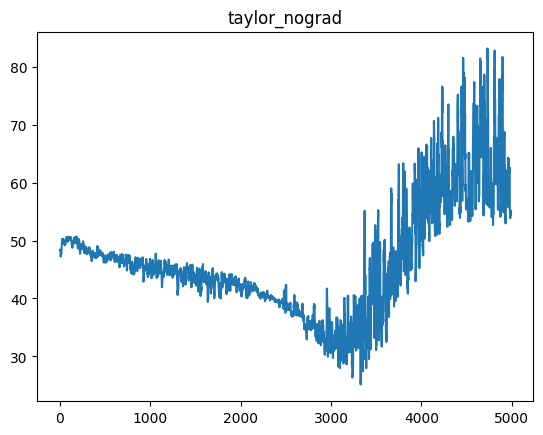

In [15]:
plt.plot(
    moving_average(
        algs["taylor_nograd"].pipeline.sample_blocks[-1].iteration.cache.grad_norm
    ),
)
plt.title("taylor_nograd")

Text(0.5, 1.0, 'lanczos_nograd')

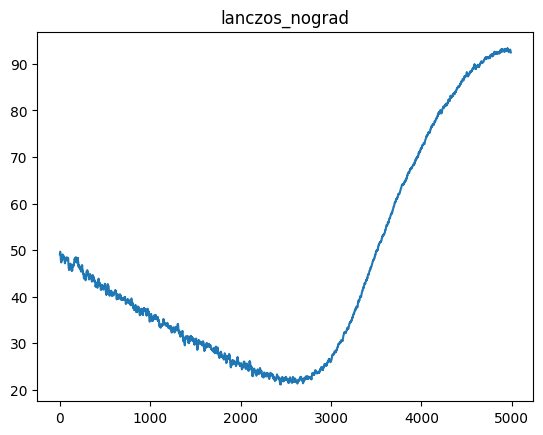

In [16]:
plt.plot(
    moving_average(
        algs["lanczos_nograd"].pipeline.sample_blocks[-1].iteration.cache.grad_norm
    ),
)
plt.title("lanczos_nograd")

In [19]:
print_log(log)


dim=8, dist=funnel
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.342284       0.320596        0.416649
ess_conf_sigma     0.029175       0.028133        0.039440
tv_mean            0.085239       0.069880        0.074748
tv_conf_sigma      0.004777       0.004413        0.006019
runtime          148.651990     226.331241      245.359711
chains_kept       30.000000      30.000000       30.000000

dim=16, dist=funnel
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.455800       0.349065        0.374049
ess_conf_sigma     0.032762       0.030311        0.041354
tv_mean            0.068217       0.074943        0.073221
tv_conf_sigma      0.003269       0.005410        0.004272
runtime          142.333083     224.879872      247.175021
chains_kept       30.000000      30.000000       30.000000

dim=32, dist=funnel
                 hmc_vanilla  taylor_nograd  lanczos_nograd
ess_mean           0.398348       0.326946        

In [18]:
plt.plot(log[0]["hist_data"][dimension][alg]["cache"].grad_norm)

NameError: name 'dimension' is not defined

In [ ]:

plt.figure(figsize=(10, 6))
window = 100  # adjust as needed

for dimension in dimensions:
    for alg in algs:
        raw = log[0]["hist_data"][dimension][alg]["cache"].accept_prob_hist
        smoothed = moving_average(np.array(raw), window_size=window)
        label = f"{alg} (dim={dimension})"
        plt.plot(smoothed, label=label, alpha=0.8)

plt.xlabel("Iteration")
plt.ylabel("Smoothed Acceptance Probability")
plt.title(f"Moving Average (window={window}) of Acceptance Probabilities")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
def moving_average(x, window_size=10):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))
window = 100  # adjust as needed

for dimension in dimensions:
    for alg in algs:
        raw = log[0]["hist_data"][dimension][alg]["cache"].accept_prob_hist
        smoothed = moving_average(np.array(raw), window_size=window)
        label = f"{alg} (dim={dimension})"
        plt.plot(smoothed, label=label, alpha=0.8)

plt.xlabel("Iteration")
plt.ylabel("Smoothed Acceptance Probability")
plt.title(f"Moving Average (window={window}) of Acceptance Probabilities")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.params.lf_step_size

In [ ]:
algs["hmc_vanilla"].pipeline.sample_blocks[-1]

In [ ]:
BenchmarkUtils.create_plot(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    log[0]["hist_data"][4]["fisher_mala"]["cache"].samples[:, :, :],
    log[0]["hist_data"][4]["fisher_mala"]["cache"].true_samples,
)

In [ ]:
BenchmarkUtils.create_plot(
    log[0]["hist_data"][256]["mala"]["cache"].samples[:, [2], :],
    log[0]["hist_data"][256]["mala"]["cache"].true_samples,
)

In [ ]:
print(f"{' ' * 30}HMC")
BenchmarkUtils.create_plot(
    log[0]["hist_data"][256]["hmc_vanilla"]["cache"].samples[:, :, :],
    log[0]["hist_data"][256]["hmc_vanilla"]["cache"].true_samples,
)

In [ ]:
print(f"{' ' * 30}HMC Taylor")
BenchmarkUtils.create_plot(
    log[0]["hist_data"][256]["taylor_nograd"]["cache"].samples[:, :, :],
    log[0]["hist_data"][256]["taylor_nograd"]["cache"].true_samples,
)

In [ ]:
print(f"{' ' * 30}HMC Lanczos")
BenchmarkUtils.create_plot(
    log[0]["hist_data"][256]["lanczos_nograd"]["cache"].samples[:, :, :],
    log[0]["hist_data"][256]["lanczos_nograd"]["cache"].true_samples,
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [2], :],
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [2], :],
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[0].iteration.cache.samples[:, [2], :],
    algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [0], :],
    algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.create_plot(
    algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.cache.samples[:, [1], :],
    algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
tv_threshold = 0.05

In [ ]:
pure_runtime

In [ ]:
runtime

In [ ]:
fig, axes = plt.subplots(
    nrows=len(dimensions),
    ncols=2,
    figsize=(13, 4 * len(dimensions),)
)
fig.suptitle(
    f"at most {tail_count_cap} last samples, burn-in={burn_in_iter_count}, "
    f"chain_count={chain_count}, "
    f"TV threshold={tv_threshold}\n" +
    f"mixture of {gaussian_count} gaussians with "
    "random means and covariance matrices"
)

for dim_ind in range(len(dimensions)):
    for alg_ind, alg in enumerate(algs.keys()):

        ticks_count = len(hist_data[dimensions[dim_ind]][alg][1])
        xticks = probe_period * jnp.arange(1, ticks_count + 1)

        axes[dim_ind, alg_ind].plot(
            xticks,
            [
                entry["tv_mean"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            label="TV mean"
        )
        axes[dim_ind, alg_ind].fill_between(
            xticks,
            [
                entry["tv_mean"] - 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            [
                entry["tv_mean"] + 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            alpha=0.1,
            label="95% CI"
        )
        axes[dim_ind, alg_ind].axhline(tv_threshold, color="r", linestyle="dashed")
        axes[dim_ind, alg_ind].set_title(f"{alg}, dim={dimensions[dim_ind]}")
        if dim_ind + 1 == len(dimensions):
            axes[dim_ind, alg_ind].set_xlabel("iteration")
        axes[dim_ind, alg_ind].set_ylabel("TV")
        axes[dim_ind, alg_ind].legend()

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmc_vanilla"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.params.sigma_prec

In [ ]:
algs["lanczos_nograd"].pipeline.sample_blocks[-1].iteration.common_params.entropy_weight.squeeze()

In [ ]:
algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.common_params.entropy_weight.squeeze()

In [ ]:
algs["taylor_nograd"].pipeline.sample_blocks[-1].iteration.common_params.entropy_weight.squeeze()

In [ ]:
algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.params.entropy_weight.squeeze()

In [ ]:
algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.params.penalty_weight.squeeze()

In [ ]:
prec = algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.params.prec[1].detach().numpy()
minv = prec @ prec.T

In [ ]:
prec = algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv = prec @ prec.T

In [ ]:
algs["hmcadaptive_hutch_lanczos"].pipeline.sample_blocks[1].iteration.params.lf_step_size

In [ ]:
algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[0].iteration.params.lf_step_size

In [ ]:
minv

In [ ]:
prec = algs["taylor_nograd"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
diff = minv - minv_l

In [ ]:
plt.hist(diff[range(len(diff)), range(len(diff))])

In [ ]:
prec = algs["hmcadaptive_hutch_taylor"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
prec = algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.prec[1].detach().numpy()
minv_l = prec @ prec.T
plt.imshow(minv_l)

In [ ]:
minv_l

In [ ]:
prec = algs["lanczos_nograd"].pipeline.sample_blocks[-1].iteration.cache.prec_params.make_prec()[1].detach().numpy()
minv_l = prec @ prec.T
plt.imshow(minv_l)

In [ ]:
minv_l

In [ ]:
prec = algs["hmcadaptive_fullent"].pipeline.sample_blocks[-1].iteration.cache.prec[19].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
minv

In [ ]:
prec = algs["hmcadaptive_noent"].pipeline.sample_blocks[-1].iteration.cache.prec[1].detach().numpy()
minv = prec @ prec.T
plt.imshow(minv)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples,
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["hmcadaptive_hutch"].pipeline.sample_blocks[-1].iteration.cache.true_samples,
)

### Reference

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

In [ ]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)